In [51]:
import cv2
import sys
import os 
import concurrent.futures
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm
from joblib import Parallel, delayed
from typing import Tuple, Union
import math

In [52]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

### Utilities

#### Folder utilities

In [ ]:
def remove_ipynb_checkpoints(starting_dir):
    for path in Path(starting_dir).rglob('.ipynb_checkpoints'):
        print("Removing directory:", path)
        for file in path.glob('*'):
            file.unlink()
        path.rmdir()

In [ ]:
def manage_and_create_paths(image_path, out_path):
    resP = out_path / image_path.parent.name / image_path.name
    if not resP.parent.exists():
        resP.parent.mkdir(parents=True, exist_ok=True)
    return resP.parent

def create_output_path(path, out_path):
    return str(manage_and_create_paths(path, out_path)) + '/' + path.name

#### Image utilities

In [ ]:
def save_image(path, img):
    cv2.imwrite(path, img)
    
def save_to_path(img, output_path, image_file_name, changes):
    remove_file_extension(image_file_name)
    image_out_path = f'{output_path}/{image_name}_{changes}.jpg'
    save_image(img, image_out_path)

def show_image(img):
    plt.imshow(img, cmap='gray')
    plt.show()

def read_cv2_image(image_path):
    return cv2.imread(str(image_path))

def read_mp_cv2_image(image_path):
    return mp.Image.create_from_file(str(image_path)), cv2.imread(str(image_path))

### Preprocessing

#### Rescaling pixel values

In [ ]:
def normalize(img):
    return img / 255.0

#### Histogram Equalization

In [ ]:
def histogram_eq(img):
    return cv2.equalizeHist(img)

#### Normalization to zero mean and unit variance

In [ ]:
def normalize_mean_var(img):
    mean, std = cv2.meanStdDev(img)
    return (img - mean) / std

#### Grayscale conversion

In [ ]:
def convert_to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#### Viola Jones face detection

In [ ]:
# returns cropped image in cv2 format
def crop_face(gray_img):
    face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = face_classifier.detectMultiScale(gray_img, scaleFactor=1.09, minNeighbors=5, minSize=(40, 40))
    for f in faces:
        x, y, w, h = [ v for v in f ]
        cv2.rectangle(gray_img, (x,y), (x+w, y+h), (255,0,0), 3)
    return gray_img[y:y+h, x:x+w]

#### Resizing

In [ ]:
# resizes images based on given size and interpolation method
def downsize_image(img, size):
    return cv2.resize(img, dsize=size, interpolation=cv2.INTER_AREA)

def upsize_image(img, size):
    return cv2.resize(img, dsize=size, interpolation=cv2.INTER_CUBIC)

### Mediapipe utilities

#### Mediapipe face detection

In [ ]:
MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red


def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int) -> Union[None, Tuple[int, int]]:
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px


def visualize(
    image,
    detection_result
) -> np.ndarray:
  """Draws bounding boxes and keypoints on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  annotated_image = image.copy()
  height, width, _ = image.shape

  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
    cv2.rectangle(annotated_image, start_point, end_point, TEXT_COLOR, 3)

    # Draw keypoints
    for keypoint in detection.keypoints:
      keypoint_px = _normalized_to_pixel_coordinates(keypoint.x, keypoint.y,
                                                     width, height)
      color, thickness, radius = (0, 255, 0), 2, 2
      cv2.circle(annotated_image, keypoint_px, thickness, color, radius)

    # Draw label and score
    category = detection.categories[0]
    category_name = category.category_name
    category_name = '' if category_name is None else category_name
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (MARGIN + bbox.origin_x,
                     MARGIN + ROW_SIZE + bbox.origin_y)
    cv2.putText(annotated_image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

  return annotated_image

In [ ]:
def crop_faces(detection_results, img_cv2, out_path):
    for d in detection_results.detections:  
        bbox = d.bounding_box
        origin_x, origin_y, width, height = bbox.origin_x, bbox.origin_y, bbox.width, bbox.height
        cropped_img = img_cv2[origin_y:origin_y+height, origin_x:origin_x+width]
        cv2.imwrite(out_path, cropped_img)
        return cropped_img

#### Mediapipe face mesh

In [ ]:
def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title('Face Blendshapes')
  plt.tight_layout()
  plt.show()

### Set parameters

#### Data paths

In [ ]:
nimh_in = Path('./data/in/NIMH-CHEFS')
fer_in = Path('./data/in/FER-2013')

nimh_out = Path('./data/out/NIMH-CHEFS')
fer_out = Path('./data/out/FER-2013')

#### Resizing size

In [ ]:
size = (256, 256)

#### Model path 

In [37]:
model_path_detect = './blaze_face_short_range.tflite'
model_path_mesh = './face_landmarker.task'

#### Model options

In [39]:
base_options_detect = python.BaseOptions(model_asset_path=model_path_detect)
options_detect = vision.FaceDetectorOptions(base_options=base_options_detect)
detector_detect = vision.FaceDetector.create_from_options(options_detect)

base_options_mesh = python.BaseOptions(model_asset_path=model_path_mesh)
options_mesh = vision.FaceLandmarkerOptions(base_options=base_options_mesh,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector_mesh = vision.FaceLandmarker.create_from_options(options_mesh)

W0000 00:00:1714939575.417829   10420 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


# Example

#### Face detection

In [ ]:
for p in (nimh_in.rglob('*.jpg')):
    path = create_output_path(p, nimh_out)
    img_mp, img_cv2 = read_mp_cv2_image(p)
    detection_results = detector_detect.detect(img_mp)
    cropped_img = crop_faces(detection_results, img_cv2, path)
    
    break

#### Face mesh

In [65]:
for p in (nimh_in.rglob('*.jpg')):
    path = create_output_path(p, nimh_out)
    img_mp, img_cv2 = read_mp_cv2_image(p)
    rgb_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_cv2)
    break

#### Process detection result, visualize detected face with bounding box

In [ ]:
image_copy = np.copy(img_mp.numpy_view())
annotated_image = visualize(image_copy, detection_results)
rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
show_image(rgb_annotated_image)
show_image(cropped_img)

In [ ]:
for p in (nimh_out.rglob('*.jpg')):
    path = create_output_path(p, nimh_out)
    img = read_cv2_image(p)
    
    img = downsize_image(img, size)

    img = convert_to_grayscale(img)
    img = histogram_eq(img) # needs grayscale to work
    
    # TODO: fix these both
    #img = normalize_mean_var(img) # results in black image?
    #img = normalize(img) # results in black image?
    
    show_image(img)
    break

#### Mesh

In [66]:
# Detect face landmarks from the input image
detection_result = detector_mesh.detect(rgb_frame)

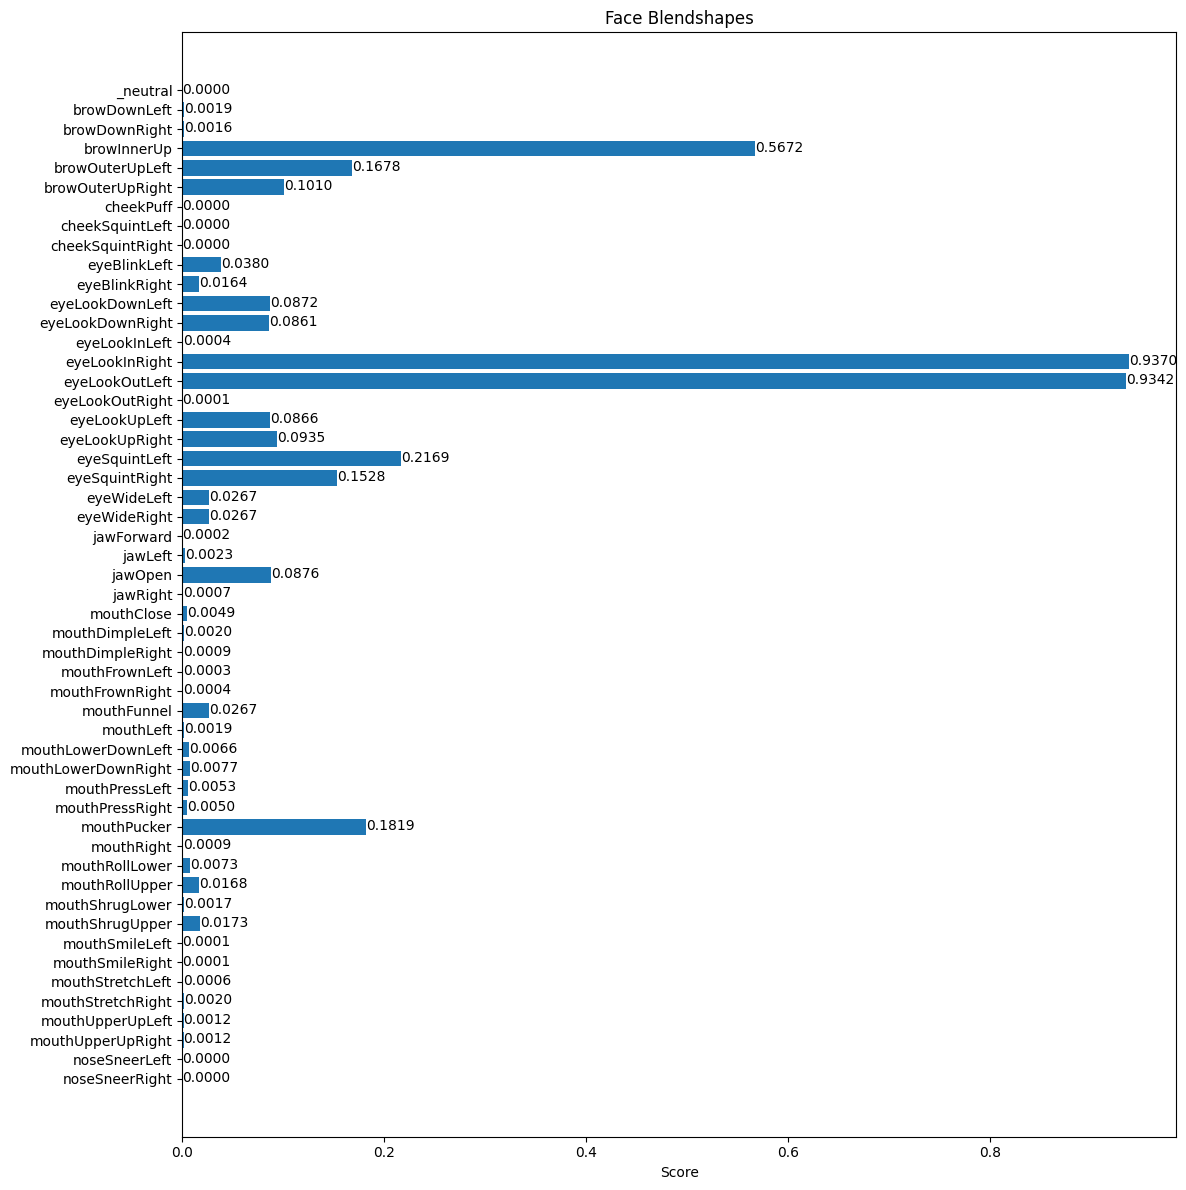

In [67]:
plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])

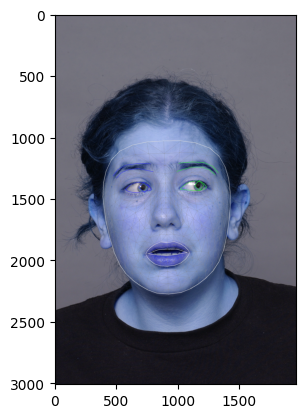

In [68]:
annotated_image = draw_landmarks_on_image(rgb_frame.numpy_view(), detection_result)
res_img = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)

plt.imshow(cv2.cvtColor(res_img, cv2.COLOR_RGB2BGR))
plt.show()

# Run

In [ ]:
remove_ipynb_checkpoints('.')

## First, run face detection and cropping:

In [ ]:
for p in tqdm(list(nimh_in.rglob('*.jpg'))):
    path = create_output_path(p, nimh_out)
    img_mp, img_cv2 = read_mp_cv2_image(p)
    img_cv2 = convert_to_grayscale(img_cv2)
    detection_results = detector_1.detect(img_mp)
    crop_faces(detection_results, img_cv2, path)
    display('done')

## Run the rest of the preprocessing as needed:

In [ ]:
for p in (nimh_out.rglob('*.jpg')):
    path = create_output_path(p, nimh_out)
    img = read_cv2_image(p)
    
    img = downsize_image(img, size)

    img = convert_to_grayscale(img)
    img = histogram_eq(img) # needs grayscale to work
    
    # TODO: fix these both
    #img = normalize_mean_var(img) # results in black image?
    #img = normalize(img) # results in black image?

    save_image(path, img)